In [12]:
include("speciale_tools.jl")
import JLD
ndimage = PyCall.pyimport("scipy.ndimage");
rasterio = PyCall.pyimport("rasterio");

In [13]:
data_folder= "/home/data/simon/processed/sentinel2_validation"
geo_lut = JLD.load(joinpath(data_folder ,"coordinates.jld"));

In [14]:
figure_folder = "/home/data/simon/result/figures_repport/sentinel2_val"

"/home/data/simon/result/figures_repport/sentinel2_val"

In [15]:
function scale2(data,k)
    res = data./k
    res[res .> 1] .= 1
    return res
end

scale2 (generic function with 1 method)

In [16]:
function load_n_resample(tiff_path,geo_lut)
    tiff = rasterio.open(tiff_path);
    transform = tiff.get_transform()
    
    idx1 = reshape((geo_lut["latitude"].-transform[4])./(transform[6]),:);
    idx2 = reshape((geo_lut["longitude"].-transform[1])./transform[2],:);
    index = [idx1,idx2];
    
    bands = [ndimage.map_coordinates(
            convert.(Float64,tiff.read(i)), index, order=1, mode="constant",cval=0)
        for i in 1:tiff.meta["count"]]
    
    bands = [reshape(elem,size(geo_lut["latitude"])) for elem in bands]
    return bands
end

load_n_resample (generic function with 1 method)

In [17]:
tiff_path = "/home/data/simon/processed/subset_resampled.tif"
bands = load_n_resample(tiff_path,geo_lut);
bands = [elem[end:-1:1,:] for elem in bands];

In [18]:
not_valid = bands[1] .< 1;

In [20]:
img = Colors.RGB.([scale2(elem,2500.0) for elem in bands[3:-1:1]]...)
file_path = joinpath(figure_folder,"s2_N_color")
FileIO.save(file_path*".jpg",img)

In [21]:
img = Colors.RGB.([scale2(elem,5000.0) for elem in bands[4:-1:2]]...)
file_path = joinpath(figure_folder,"s2_F_color")
FileIO.save(file_path*".jpg",img)

In [22]:
ndwi = (bands[2] .- bands[4]) ./ (bands[2] .+ bands[4]);
ndwi[not_valid] .= -1;
water = (ndwi.> 0);

1330×1425 BitArray{2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

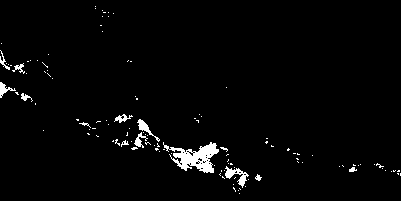

In [23]:
Colors.Gray.(water[700:900,400:800])

In [24]:
cloud = (bands[1].>4000) .& (bands[2].>4000) .& (bands[3].>4000) .& (bands[4].>4000);

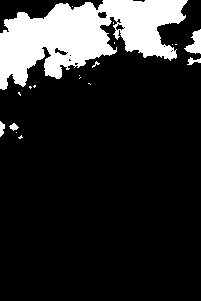

In [25]:
 Colors.Gray.(cloud)[400:700,200:400]

In [26]:
img_save = add_mask(img,water ,(0,0,1))
img_save = add_mask(img_save,cloud ,(0,0,0))

file_path = joinpath(figure_folder,"s2_clouds_water")
FileIO.save(file_path*".jpg",img_save)

In [17]:
file_name = joinpath(data_folder,"S2_water.jld")
JLD.save(file_name, "data",water);

In [18]:
file_name = joinpath(data_folder,"S2_clouds.jld")
JLD.save(file_name, "data",cloud);